# Small-Cap Stock Price-Movement Prediction and Price-Target Forecasting

#### Author: Jake Oddi

## Business Problem

Quantitative analysis of stocks has become increasingly popular over the past decades, to the point where it is ubiqiutous among insitutional investors. Among individual investors, however, it is less widespread. This is due to a general lack of the technical skills required to perform such analysis. I ran into this issue myself when constructing my portfolio. I predict an easy-to-use, open-source model would serve to benefit this population. 

This project applies classification methods to the daily price data of stocks with market capitalizations between \\$75M and \\$1B from the past three years to predict intraday price movements. Instances where the closing price exceeds the opening price are considered positive cases, and instances where the opposite is true are considered negative. The timescale for this data (daily) meant predicting the position of closing price relative to opening price was a desirable classification problem, as it is harder to do with time series modeling. Conversely, time series modeling to predict exact price is much better suited to interday prices, which is what I use it for. 

My analysis focuses on small-cap companies because they typically see lower trading volumes, and therefore have more inefficiencies that can be exploited and less noisey trading prices. Conversely, this makes trades harder to execute at desirable prices. 

Predictions of price-movement direction and price-target are nowhere near perfect, and should only be used in conjunction with additional information. In general, quantitative analysis should be combined with fundamental analysis.

To use the following project for one's own analysis, one must first create a TD Ameritrade Developer account, create an app, and fetch his or her API key, replacing mine in the form of the 'consumer_key' variable. Next, under the 'Selection' section, one should change the 'ticker_list' variable to include whichever tickers are to be included in his or her model. This will allow one to run the rest of the code and yield the same analysis as is already shown.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(seed = 1)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import json
import time
from config import ameritrade_credentials
from price_forecasting_code.functions import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import itertools
import statsmodels.api as sm
import warnings
import tensorflow as tf
tf.random.set_seed(100)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.callbacks import History
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Data Understanding

### Data Acquisition

To decide which companies to model, I employed a stock screener from [TD Ameritrade](https://research.tdameritrade.com/grid/public/screener/stocks/overview.asp) to select stocks with market caps within my desired range. This yielded 8027 results. I filtered this down to 3055 results by removing companies worth less than \\$75M, as many companies below that threshold had such low trading volumnes that they were not conducive to modeling. For the sake of ease-of-use and proof-of-concept, I filtered this down further by randomly sampling 500. I then gathered daily price data from the past three years using [TD Ameritrade's Price History API](https://developer.tdameritrade.com/price-history/apis). Of these 500, the API failed for 157, leaving 343. Of the remaining, I selected only those with 756 days of data to use in my analysis, leaving me with 160 stocks. 

In [2]:
# Read in the screener
screen = pd.read_csv('./data./ameritrade_stock_screener.csv', header = 0)

# Take a first look
screen.head()

,Symbol,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta
0,AAAIF,ALTERNATIVE INVESTMENT TRUST UNITS,2.856715e+07,NaN,NaN,--,+0.2
1,AACG,ATA Creativity Global(ADR),3.713346e+07,Consumer Discretionary,Diversified Consumer Services,--,+1.7
2,AACH,AAC Holdings Inc,4.025300e+05,Health Care,Health Care Providers & Services,--,+2.7
3,AACQ,Artius Acquisition Inc,9.341573e+08,NaN,NaN,--,--
4,AACS,"American Commerce Solutions, Inc.",6.946900e+05,Industrials,Road & Rail,--,-1.0


#### Screener Cleaning

In [3]:
# Rename screener columns
screen.columns = ['ticker', 'company', 'market_cap', 'sector', 'industry', 'dividend_yield', 'beta']

# Screening only for companies worth > $75M
screen = screen[screen['market_cap'] >= 75000000]

#### Selection

In [4]:
# Instantiate a list of 500 random integers for selection of df indices from the screener
rand_list = np.random.randint(0, screen.shape[0], 500)

# Filter the screener using the list of random indices
filtered_screen = screen.iloc[rand_list]

# Create a list of the tickers of all stocks selected by the filter
ticker_list = filtered_screen['ticker'].values

#### API Call - Configuration

In one's own analysis using Ameritrade's API, he or she must use their own API key in place of my 'consumer_key' variable.

In [5]:
# Import personal client ID
client_id = ameritrade_credentials.consumer_key

# Set payload params
period = '3'
period_type = 'year'
frequency = '1'
frequency_type = 'daily'
start_date = '1512172799'
end_date = '1606867199'

# Define payload
payload = {'apikey': client_id,
           'periodType': period_type,
           'frequencyType': frequency_type,
           'frequency': frequency,
           'period': period,
#            'endDate': end_date,
#            'startDate': start_date,
           'needExtendedHoursData': 'false'
          }

#### API Call

In [6]:
# A list of dfs is instantiated, where each stock's data is stored in a dataframe
df_list, fail_cache = get_data_from_ameritrade(ticker_list, payload)

In [7]:
print('Length of df_list:', len(df_list))
print('Length of fail_cache', len(fail_cache))

Length of df_list: 453
Length of fail_cache 47


#### Final Filtering

The last step in the filtering process cuts the number of stocks down to 160.

In [8]:
# Filtering only for stocks with greater than 755 days of price data
df_list = list(filter(lambda x: x.shape[0] >= 755, df_list))

In [9]:
len(df_list)

228

### Understanding

The API returned a dataframe with the following columns built in for each stock: opening price, daily high, daily low, closing price, datetime, volume, and ticker.

In [10]:
df_list[0].head()

,open,high,low,close,volume,datetime,ticker
0,20.10,20.450,19.800,20.10,351142,1516860000000,FRGI
1,20.10,20.500,19.550,19.95,213098,1516946400000,FRGI
2,19.95,20.125,19.700,19.95,174147,1517205600000,FRGI
3,19.85,20.050,18.955,19.55,255009,1517292000000,FRGI
4,19.55,19.650,19.050,19.20,205910,1517378400000,FRGI


## Cleaning

The first step is to check for NaN values in each of the dataframes. If a dataframe contains a NaN value, the below loop will return the ticker associated with that dataframe.

In [11]:
# Checking for NaN values in each dataframe
for df in df_list:
    if df.isna().sum().sum() != 0:
        print(df['ticker'][0])

Next I'll check the datatypes of each column of each dataframe.

In [12]:
df_list[0].dtypes

open        float64
high        float64
low         float64
close       float64
volume        int64
datetime      int64
ticker       object
dtype: object

The last thing to check is that each dataframe has the expected number of datapoints - 756.

In [13]:
for df in df_list:
    if df.shape[0] < 755:
        print(df['ticker'][0])

The data arrives quite clean. The only changes to be made are to the datetimes, which arrive in the unix format and need to be converted to a regular datetime, then set as the index. 

In [14]:
df_list = clean_dates(df_list)

### A First Look

For the purpose of examining all the stocks in the dataset, I need concetanate them all into one dataframe.

In [15]:
# Concatenating all the dfs in df_list
df_joined = pd.concat(df_list)

# Examining Shape
df_joined.shape

(172140, 6)

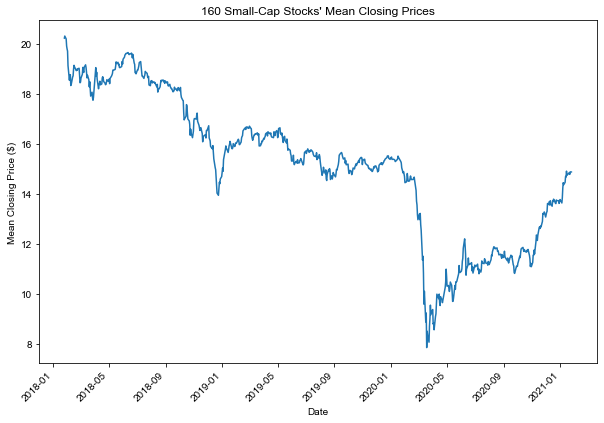

In [16]:
# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()

# Assigning x and y variables so they can be graphed
x = date_close_gb.keys()
y = date_close_gb.values

# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.set_theme()
sns.lineplot(x = x, y = y)
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "160 Small-Cap Stocks' Mean Closing Prices")
fig.autofmt_xdate(rotation=45)
plt.show()

As shown in the plot above, the average closing price of small cap stocks has been in a downward trend since year-end 2017, falling sharply around March 2020 due to the Coronavirus pandemic and its economic impact, failing to fully recover by December 2020. The trend is much more negative than the overall market, which rose consistently until March 2020, where it fell but proceeded to exceed pre-Covid levels by December 2020. 

## Feature Engineering

The first feature I engineered was my target variable. The target signifies whether a stock's closing price for one day exceeds its opening price. If this is the case, the target variable = 1. If the opposite is true, wherein the stock closes lower than it opened, the target variable = 0. If the closing and opening prices are exactly the same, the target variable = 2.

In [17]:
df_list = create_intra_clf_target(df_list)

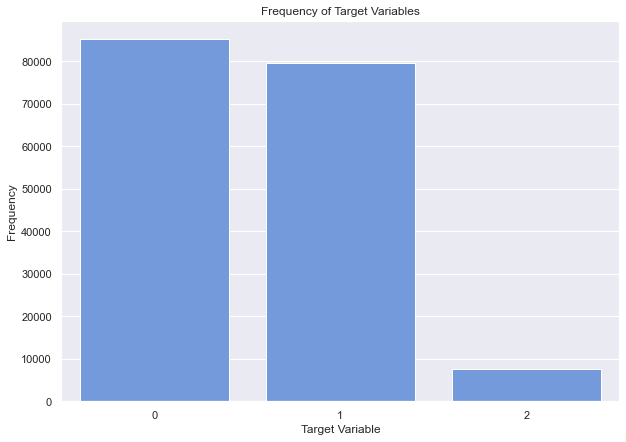

In [88]:
# Concatenating again after target variables have been created
df_joined_2 = pd.concat(df_list)

# Examining value counts of target variables
target_counts = df_joined_2['intra_clf_target'].value_counts()

# Assigning x and y variables for barplot
x = target_counts.keys()
y = target_counts.values

# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.set_theme()
sns.barplot(x = x, y = y)
ax.set(xlabel = 'Target Variable', 
       ylabel = 'Frequency', 
       title = "Frequency of Target Variables")
ax.set_xticklabels(labels = ['Down', 'Up', 'No Change'])
sns.barplot(x = x, y = y, color = 'cornflowerblue')
plt.show()

As shown in the barplot above, there are relatively equivalent amounts of positive and negative cases, but high imbalance when compared to the neither case. As a result, I will use F1-Score as my evaluation metric.

Unlike for classification, the target variable for my time series analysis does not need to be engineered. It is simply the closing price of each day I want to forecast into the future.

I know that moving averages are important technical indicators for price movement, so the next features I created served to account for both long and short-term moving averages. I created features for a 10, 50, and 200 day moving average.

In [19]:
# Takes in list of dfs, creates three different moving average features - 10, 50, and 200 days.
df_list = create_moving_avs(df_list)

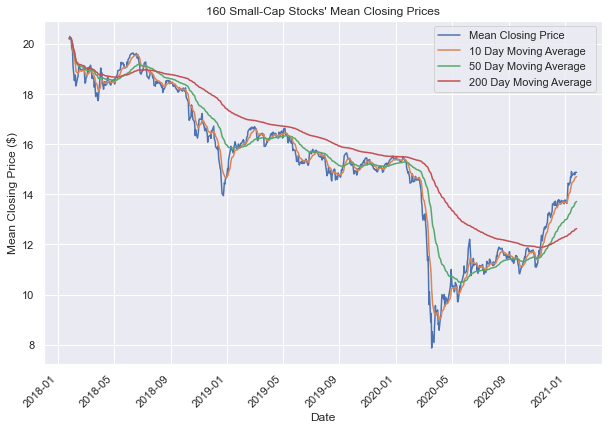

In [20]:
# Concatenating again after moving averages have been created
df_joined_3 = pd.concat(df_list)

# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()

ten_day_gb = df_joined_3.groupby(df_joined_3.index)['10_day_ma'].mean()
fifty_day_gb = df_joined_3.groupby(df_joined_3.index)['50_day_ma'].mean()
twohundred_day_gb = df_joined_3.groupby(df_joined_3.index)['200_day_ma'].mean()

# Assigning x1 and y1 to date and closing price
x1 = date_close_gb.keys()
y1 = date_close_gb.values

# Assigning x2 and y2 to the ten day moving average
x2 = ten_day_gb.keys()
y2 = ten_day_gb.values

# Assigning x3 and y3 to the fifty day moving average
x3 = fifty_day_gb.keys()
y3 = fifty_day_gb.values

# Assigning x4 and y4 to the two hundred day moving average
x4 = twohundred_day_gb.keys()
y4 = twohundred_day_gb.values


# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.set_theme()
sns.lineplot(x = x1, y = y1, label = 'Mean Closing Price')
sns.lineplot(x = x2, y = y2, label = '10 Day Moving Average')
sns.lineplot(x = x3, y = y3, label = '50 Day Moving Average')
sns.lineplot(x = x4, y = y4, label = '200 Day Moving Average')
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "160 Small-Cap Stocks' Mean Closing Prices")
fig.autofmt_xdate(rotation=45)
plt.show()

The various moving averages are shown in comparison to the mean closing prices for each day. As one would expect, the 200 day average is much less affected by small price movements, as opposed to the 10 day average, which follows the mean closing price very closely.

An important concept in quantitative finance is <b>Mean Reversion</b>, which holds that stocks tend to revert to the moving average of their prices.

The following function creates price change (%) features with intervals ranging from one to four days for each df.
It calculates % price changes relative to the day before the observed date in order to avoid prediction using unknown data.

In [21]:
df_list = create_pct_price_changes(df_list)

Below is an example of a dataframe with all features engineered:

In [22]:
df_list[0].head()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2018-01-25 06:00:00,20.10,20.450,19.800,20.10,351142,FRGI,2,20.100000,20.100000,20.100000,0,0,0,0
2018-01-26 06:00:00,20.10,20.500,19.550,19.95,213098,FRGI,0,20.017500,20.023500,20.024625,0,0,0,0
2018-01-29 06:00:00,19.95,20.125,19.700,19.95,174147,FRGI,2,19.990365,19.998014,19.999501,0,0,0,0
2018-01-30 06:00:00,19.85,20.050,18.955,19.55,255009,FRGI,0,19.845285,19.879202,19.885434,0,0,0,0
2018-01-31 06:00:00,19.55,19.650,19.050,19.20,205910,FRGI,0,19.660041,19.732282,19.745592,0,0,0,0


Note: The first five observed days contain no pct price change values. This is because there was no data before the first observed day, so all values begin on the fifth day. Below is a better representation:

In [23]:
df_list[0].tail()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2021-01-19 06:00:00,15.18,15.5883,14.5800,14.83,144118,FRGI,0,13.745846,12.181001,10.292025,3,4,3,9
2021-01-20 06:00:00,14.61,15.2900,14.2040,15.21,143702,FRGI,1,14.012056,12.299785,10.340987,1,4,5,5
2021-01-21 06:00:00,15.21,15.6100,14.9068,15.35,100684,FRGI,1,14.255318,12.419401,10.390855,2,3,7,8
2021-01-22 06:00:00,15.19,15.4200,14.9501,15.38,100260,FRGI,1,14.459806,12.535503,10.440524,0,3,4,8
2021-01-25 06:00:00,15.24,16.0450,15.2200,15.69,91026,FRGI,1,14.683478,12.659209,10.492786,0,1,3,4


## Selecting a Sample

Due to time constraints, I wanted to select a subset of stocks on which to perform my analysis. I've chosen to use capital markets stocks, as their prices are affected the least by external influences. For example, biotechnology companies' prices are heavily influenced by their bringing new treatments and technologies to market. Capital markets companies performances are the most dependant on overall stock market performance out of all the industries in the dataset. 

In [24]:
# Selecting tickers from final df list
final_list = [x['ticker'][0] for x in df_list]

# Filtering screen df with 'industry' column for only those in the final screen
sample = screen[screen['ticker'].isin(final_list)]

# Getting tickers for the eight capital markets companies
cap_markets_tickers = list(sample[sample['industry'] == 'Capital Markets']['ticker'])

# Getting tickers for all other companies
other_tickers = list(sample[sample['industry'] != 'Capital Markets']['ticker'])

In [25]:
# Examining the eight capital markets firms
sample[sample['industry'] == 'Capital Markets']

,ticker,company,market_cap,sector,industry,dividend_yield,beta
750,BANX,StoneCastle Financial Corp,136071720.0,Financials,Capital Markets,7.45%,+0.8
1429,CGBD,TCG BDC Inc,625592990.0,Financials,Capital Markets,11.59%,+2.2
1725,COWN,Cowen Inc,662763700.0,Financials,Capital Markets,1.29%,+1.5
2935,GAIN,Gladstone Investment Corporation,332714100.0,Financials,Capital Markets,8.32%,+1.4
5730,PNNT,PennantPark Investment Corp.,304719520.0,Financials,Capital Markets,10.48%,+2.0
5955,PZN,"Pzena Investment Management, Inc.",518829300.0,Financials,Capital Markets,1.69%,+1.5
6465,SFE,"Safeguard Scientifics, Inc",148131370.0,Financials,Capital Markets,--,+1.3
6831,SSSS,SuRo Capital Corp,250119840.0,Financials,Capital Markets,4.02%,+1.7
7759,WETF,Wisdom Tree Investments Inc,750605190.0,Financials,Capital Markets,2.38%,+1.7
7770,WHF,WhiteHorse Finance Inc,287644000.0,Financials,Capital Markets,10.19%,+1.6


In [26]:
# Instantiating list of capital markets stocks
cm_df_list = []

# Instantiating list of all other stocks
other_list = []

# If the company in the larger list of dfs is part of the cap markets list,
# append it to the list of cap markets companies
# If it's not on the cap markets list, append it to a list of other companies
for df in df_list:
    if df['ticker'][0] in cap_markets_tickers:
        cm_df_list.append(df)
    if df['ticker'][0] in other_tickers:
        other_list.append(df)

# Deleting two WETF duplicates
del(cm_df_list[0])
del(cm_df_list[-1])

In [27]:
len(cm_df_list)

10

Below is a barplot showing the distribution of the various sectors present in my final 160 stocks. Financials, which contain capital markets, dominate the group.

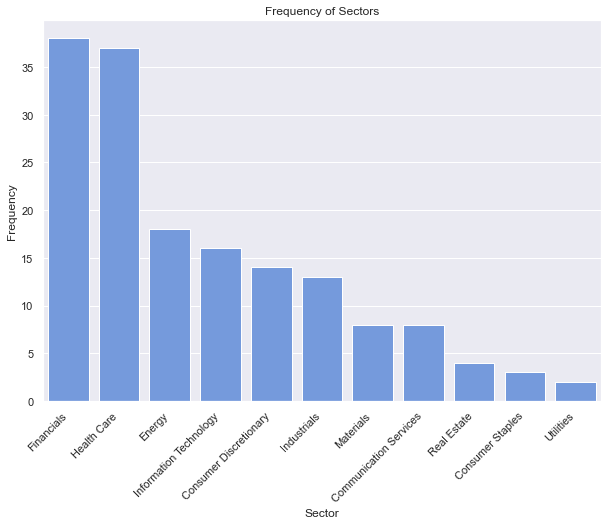

In [28]:
# Examining value counts for each sector
sector_counts = sample['sector'].value_counts()

# Assigning x and y variables for barplot
sector_x = sector_counts.keys()
sector_y = sector_counts.values

# Constructing plot
fig, ax = plt.subplots(figsize = (10,7))
sns.barplot(x = sector_x, y = sector_y)
ax.set(xlabel = 'Sector', 
       ylabel = 'Frequency', 
       title = "Frequency of Sectors")
ax.set_xticklabels(rotation = 45, ha = 'right', labels = sector_x)
sns.set_theme()
sns.barplot(x = sector_x, y = sector_y, color = 'cornflowerblue')
plt.show()

Next I wanted to test my hypothesis of capital markets stocks closely following the market. Below shows the mean daily closing prices of all 160 stocks, the eight capital markets stocks, and the 152 stocks that don't belong to the capital markets industry. Because the 160 is largely composed of the 152 other stocks, it's not surprising that the green line representing the other stocks so closely follows the overall trend that it obscures the blue line.

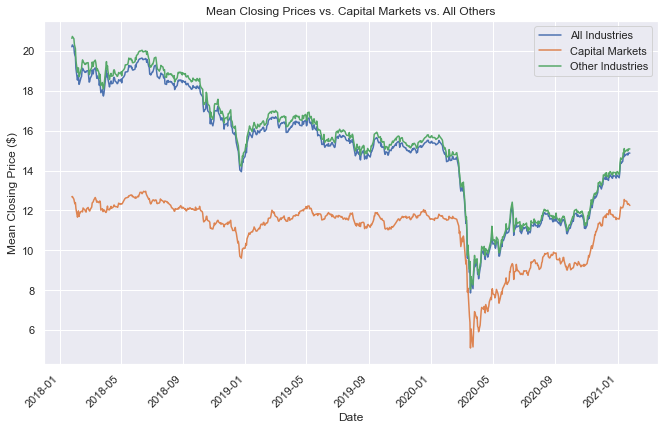

In [29]:
# Concatenating all the dfs in cm_df_list
cm_joined = pd.concat(cm_df_list)

# Concatenating all the dfs in other_list
others_joined = pd.concat(other_list)

# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()
cm_close_gb = cm_joined.groupby(cm_joined.index)['close'].mean()
other_close_gb = others_joined.groupby(others_joined.index)['close'].mean()

# Assigning x and y variables so they can be graphed
x = date_close_gb.keys()
y = date_close_gb.values

# Cap Markets x and y
x1 = cm_close_gb.keys()
y1 = cm_close_gb.values

# All others x and y
x2 = other_close_gb.keys()
y2 = other_close_gb.values

# Visualizing
fig, ax = plt.subplots(figsize = (11,7))
sns.lineplot(x = x, y = y, label = 'All Industries')
sns.lineplot(x = x1, y = y1, label = 'Capital Markets')
sns.lineplot(x = x2, y = y2, label = 'Other Industries')
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "Mean Closing Prices vs. Capital Markets vs. All Others"
      )
fig.autofmt_xdate(rotation=45)
sns.set_theme()
plt.show()

## Modeling and Results - Price Movement Classification

### Initial Model

My baseline model was a KNN and was used to evaluate my engineered features. 

In [30]:
# Assign a test dataframe on which to evaluate
df_test = df_list[0]

# Split into train and test sets on February 2, 2020
train = df_test[:'2020-02-02']
test = df_test['2020-02-02':]

X_train, y_train = train[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], train['intra_clf_target']

X_test, y_test = test[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], test['intra_clf_target']

# Instantiate the KNN Classifier
knn = KNeighborsClassifier()

# Instantiate the scaler
scaler = StandardScaler()

# Fit, transform on the train set, only transform on the test set
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test data
preds = knn.predict(X_test)

# Evaluate metrics
print('Acc:', accuracy_score(y_test, preds)) # price changes improved to .486 from .45
print('Precision:', precision_score(y_test, preds, average = 'weighted')) # improved from .44 with price change feature

Acc: 0.4715447154471545
Precision: 0.46622927626335087


My initial accuracy and precision scores were .451 and .448, respectively; however, the addition of my moving average and percent-price-change features saw these increase to .478 and .472, respectively.

### Gridsearch and Cross Validation

Next I wanted to add another model - Random Forest - then gridsearch my parameters and cross validate my evaluation metric, F1-Score. Because I have a high imbalance among my three classes, F1-Score serves to remedy much of the bias in scoring this may cause, as it takes into account precision and recall. I gridsearched only on the first ten dataframes in my list of dataframes for the sake of time. For each df and respective model fit to it, a dictionary with the parameters used in the model as well as the F1-Score attained with those parameters. For each model, I compile these into a list, then pick the parameters to use in my final models based on frequency.  

Because of the time series nature of the data, I had to create a custom means of cross validating my scoring metric. I split the data into five folds - one representing 60% of the data and four others, each representing 10%. Each of the subsets was in sequential order in relation to all others. I would train on the first, large set and test on the second set. Once I have my scoring metrics from that iteration, I would combine the original train and test sets into one training set then test on the next set in the order. I continued this process until I had tested on all four 'testing' sets, after which I averaged my metrics.

In [31]:
# Instantiate Random Forest and KNN Classifiers to be used in further modeling
rfc = RandomForestClassifier(random_state = 1)
knn = KNeighborsClassifier()

# Parameter grid for random forest gridsearch
rfc_param_grid = {'n_estimators': [500, 750, 1000],
                  'class_weight': ['balanced'],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [3, 5, 7]
             }

# Parameter grid for knn gridsearch
knn_param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                  'leaf_size': [15, 30, 40]
                 }

#### Random Forest

In [32]:
# Create a list of random forest best params and scores for first 10 dfs
rfc_gs_results = []

for df in df_list[:10]:
    # Gridsearch and Cross Validation 
    result = time_cross_validate(df = df, model = rfc, param_grid = rfc_param_grid)
    
    # Appending to list of dicts
    rfc_gs_results.append(result)            

In [33]:
rfc_gs_results

[{'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.4862492511607587},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.41322427253151706},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.4296741965435964},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 5,
  'n_estimators': 750,
  'best_score': 0.42508292405495696},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 500,
  'best_score': 0.43733165201052093},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.4934463976392552},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 500,
  'best_score': 0.41153136631897436},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_

In [34]:
# Calculating mean random forest F1 score for the first 10 stocks
np.mean([x['best_score'] for x in rfc_gs_results])

0.4458655306492069

The highest performing parameters for the Random Forest based on this gridsearch are:
* max_depth = 7
* n_estimators = 1000
* criterion = 'gini'
* class_weight = 'balanced'

#### KNN

In [35]:
# Create a list of knn best params and scores for first 10 dfs
knn_gs_results = []

for df in df_list[:10]:
    # Gridsearch and Cross Validation
    result = time_cross_validate(df = df, model = knn, param_grid = knn_param_grid)
    
    # Appending to list of dicts
    knn_gs_results.append(result)            

In [36]:
knn_gs_results

[{'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 7,
  'best_score': 0.5738488871133964},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 7,
  'best_score': 0.463830541960602},
 {'algorithm': 'ball_tree',
  'leaf_size': 15,
  'n_neighbors': 5,
  'best_score': 0.4614377047824746},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.49170279675858397},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.4521655202404068},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 5,
  'best_score': 0.5248551157418677},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.474781704824014},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.49317313962377823},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 5,
  'best_score': 0.4588477823484942},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4772543482064321}]

In [37]:
# Calculating mean KNN F1 score for the first 10 stocks
np.mean([x['best_score'] for x in knn_gs_results])

0.487189754160005

The highest performing parameters for the KNN based on this gridsearch are:
* algorithm = 'auto'
* leaf_size = 15
* n_neighbors = 3

### Final Classification Models

#### Analysis of Results and Comparing Models

For my final Random Forest and KNN models, I used the parameters I obtained through my gridsearch. I anticipated that there would not be a clear favorite among the two models, and that instead KNN would perform better on some stocks while Random Forest would perform better on others. I evaluated both models on the first ten stocks, creating a list of tuples of F1-Scores. The first item in each tuple corresponds to the Random Forest F1 and the second to the KNN F1.

In [38]:
# Creating a list of tuples to compare model performance on each stock
comparison_list = compare_scores(cm_df_list)
comparison_list

[(0.3025748149493665, 0.45713688147437315),
 (0.39520518467886884, 0.5695980516403558),
 (0.3309852915116073, 0.5652475720843729),
 (0.4824561403508772, 0.47197178005248325),
 (0.547658310839237, 0.4982572485372037),
 (0.38204215860693297, 0.453166104139766),
 (0.44796931248796185, 0.5339458058025849),
 (0.46336669259355284, 0.48553900160548363),
 (0.47289649739909473, 0.5130220816156967)]

In [39]:
# Splitting the above tuples into individual lists of F1-Scores for the purpose of visualization
rfc_f1 = [x[0] for x in comparison_list]
knn_f1 = [x[1] for x in comparison_list]

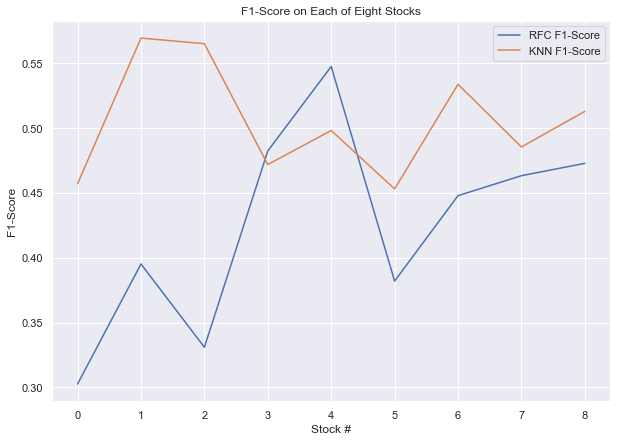

In [40]:
fig, ax = plt.subplots(figsize = (10,7))
sns.lineplot(x = range(len(rfc_f1)), y = rfc_f1, label = 'RFC F1-Score')
sns.lineplot(x = range(len(knn_f1)), y = knn_f1, label = 'KNN F1-Score')
ax.set(xlabel = 'Stock #',ylabel = 'F1-Score', title = 'F1-Score on Each of Eight Stocks')
sns.set_theme()
# ax.axhline(y = np.mean(rfc_f1), xmin = .05, xmax = .95)
# ax.axhline(y = np.mean(knn_f1), xmin = .05, xmax = .95, color = 'orange')
# ax.text(x = 9.5, y = np.mean(rfc_f1), s = str(round(np.mean(rfc_f1), 2)))
# ax.text(x = 9.5, y = np.mean(knn_f1), s = str(round(np.mean(knn_f1), 2)))
ax.legend()
plt.show()

Contrary to my initial assumption, the KNN F1-Score (.48) outperformed the RF F1-Score (.43) by .05 on average, as shown in the graph above.

# Time Series Analysis

In order to predict exact prices as opposed to price movements, I needed to use time series models like ARMA, which stands for Autoregressive Moving Average. The autoregressive portion of the title refers to the model's ability to predict a value based on values that came chronologically before it. The moving average portion is self explanatory, referring to the model's use of a moving average component in its forecasting.

## Data Inspection

I began by taking a look at a dataframe from my capital markets stock list to use as a test df to develop my first simple model.

In [41]:
cm_df_list[0].head()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2018-01-22 06:00:00,11.40,11.85,11.40,11.80,96168,SFE,1,11.800000,11.800000,11.800000,0,0,0,0
2018-01-23 06:00:00,11.75,11.80,11.40,11.55,93120,SFE,0,11.662500,11.672500,11.674375,0,0,0,0
2018-01-24 06:00:00,11.55,11.70,11.30,11.35,68251,SFE,0,11.536877,11.560672,11.565167,0,0,0,0
2018-01-25 06:00:00,11.35,11.60,11.25,11.50,169488,SFE,1,11.524728,11.544582,11.548630,0,0,0,0
2018-01-26 06:00:00,11.55,11.75,11.55,11.65,83289,SFE,1,11.560690,11.567385,11.569312,0,0,0,0


In [42]:
df_test = cm_df_list[0]['close']

df_test.head()

datetime
2018-01-22 06:00:00    11.80
2018-01-23 06:00:00    11.55
2018-01-24 06:00:00    11.35
2018-01-25 06:00:00    11.50
2018-01-26 06:00:00    11.65
Name: close, dtype: float64

<AxesSubplot:xlabel='datetime'>

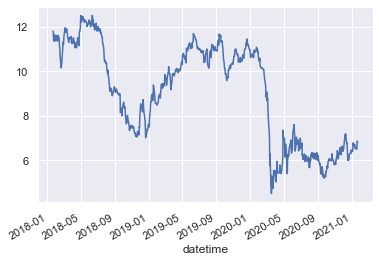

In [43]:
df_test.plot()

## ARMA

### Detrending

Next I move on to detrending in order to remove periodicity and acheive stationarity in my time series. I employ differencing to do this. ARMA models assume input data is stationary.

In [44]:
df_diff = df_test.diff(periods = 1)
df_diff.dropna(inplace = True)

<AxesSubplot:xlabel='datetime'>

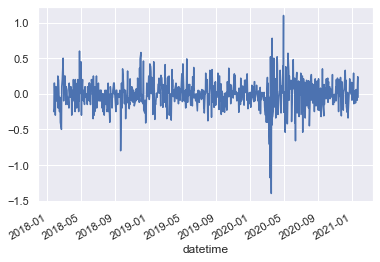

In [45]:
df_diff.plot()

In [46]:
# Dickey-Fuller test for stationarity
d_f = adfuller(df_diff)
d_f

(-17.678583768815344,
 3.617007147229186e-30,
 1,
 754,
 {'1%': -3.439052522969989,
  '5%': -2.8653808299915013,
  '10%': -2.5688152592363274},
 -274.8746080293622)

### Train/Test Split

In [31]:
end_train_date = '2020-12-01'
end_test_date = '2020-12-18'

In [57]:
# Slicing my data based on set dates
train = df_diff[:end_train_date]
test = df_diff[end_train_date:end_test_date]

### Modeling

Through trial and error I arrive at order parameters of 4 and 4 for AR and MA, respectively. These parameters dictate how many autoregressive and moving average terms exist within the ARMA function. They yielded me the lowest AIC score.

In [192]:
# Training the ARMA model on the training data
mod_arma = ARMA(train, order = (4,4)) # how to decide on order again?
res_arma = mod_arma.fit()
res_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                  734
Model:                     ARMA(4, 4)   Log Likelihood                 218.564
Method:                       css-mle   S.D. of innovations              0.180
Date:                Mon, 04 Jan 2021   AIC                           -417.129
Time:                        23:17:33   BIC                           -371.144
Sample:                             0   HQIC                          -399.392
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0148      0.008     -1.849      0.065      -0.031       0.001
ar.L1.close     1.0522   4.88e-05   2.16e+04      0.000       1.052       1.052
ar.L2.close    -0.6510      0.000  -4342.666      0.000      -0.651      -0.651
ar.L3.close     1.1767   2.45e-06    4.8e+05      0.000       1.177       1.177
ar.L4.close    -0.8154   8.58e-05  -9501.327      0.000      -0.816      -0.815
ma.L1.close    -1.0817      0.019    -58.208      0.000      -1.118      -1.045
ma.L2.close     0.6793      0.006    112.718      0.000       0.667       0.691
ma.L3.close    -1.1739      0.009   -124.085      0.000      -1.192      -1.155
ma.L4.close     0.8632      0.016     54.891      0.000       0.832       0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3372           -0.9414j            1.0000           -0.3047
AR.2           -0.3372           +0.9414j            1.0000            0.3047
AR.3            1.0587           -0.3248j            1.1074           -0.0474
AR.4            1.0587           +0.3248j            1.1074            0.0474
MA.1           -0.3371           -0.9415j            1.0000           -0.3047
MA.2           -0.3371           +0.9415j            1.0000            0.3047
MA.3            1.0171           -0.3521j            1.0763           -0.0530
MA.4            1.0171           +0.3521j            1.0763            0.0530
-----------------------------------------------------------------------------
"""

In [213]:
# Forecasting with the trained model
preds = res_arma.forecast(steps = 14)

### Model Evalutation

Below is a lineplot comparing the true prices with the predicted ones. 

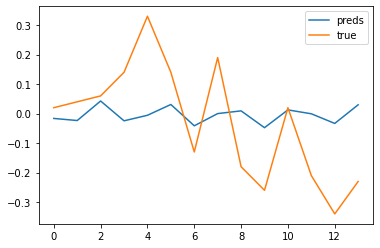

In [214]:
plt.plot(range(0,14), preds[0], label = 'preds')
plt.plot(range(0,14), test[:14], label = 'true')
plt.legend()

In [215]:
# Calculating RMSE of my forecasts
rmse = np.sqrt(mean_squared_error(test[0:14].values, preds[0]))
rmse

0.18662607399567527

A RMSE of .1866 means that the model's predictions differ from the actual differenced prices by $.1866 accross the 14 days; however, the model appears to be underfitting the data.

### Gridsearched ARMA

After building my first simple ARMA model, I wanted to gridsearch the p and q parameters to find the combination that would produce the lowest RMSE for each capital markets stock. For each stock, I predict fourteen days after the end of the training data. I mainly use RMSE as my scoring parameter, as I feel this best captures the dollar difference between actual and predicted prices.

In [48]:
# Defining AR and MA order components
p = range(0,5) # AR
q = range(0,5) # MA

In [49]:
# Creating every combination of p, d, and q parameters
pq = itertools.product(p, q)

# Converting from itertools product object to list
pq = list(pq)

In [51]:
# Compiling a list of the best performing order parameters for each stock
best_model_list = gridsearch_arma_multiple(cm_df_list, 
                                           orders_list = pq, 
                                           end_train_date = end_train_date, 
                                           end_test_date = end_test_date,
                                           n_days = 14)
best_model_list

[['SFE',
  [{'order': (4, 4), 'aic': -264.7011580465505, 'rmse': 0.18856737936549975},
   {'order': (4, 4), 'aic': -264.7011580465505, 'rmse': 0.18856737936549975}]],
 ['SSSS',
  [{'order': (4, 1), 'aic': 141.74483214724182, 'rmse': 0.338130014369284},
   {'order': (2, 4), 'aic': 132.64291999091802, 'rmse': 0.3703264648148025}]],
 ['CGBD',
  [{'order': (1, 1), 'aic': 101.93548060527019, 'rmse': 0.14291862342870668},
   {'order': (4, 4), 'aic': 85.75743758995463, 'rmse': 0.15436297300266055}]],
 ['GAIN',
  [{'order': (1, 1), 'aic': -192.6038387553981, 'rmse': 0.09885438219902602},
   {'order': (4, 4), 'aic': -212.4087587285985, 'rmse': 0.1021107478775747}]],
 ['BCOR',
  [{'order': (3, 3), 'aic': 1623.3891513896895, 'rmse': 0.26436447910736605},
   {'order': (0, 0), 'aic': 1621.672382740645, 'rmse': 0.2822264834322718}]],
 ['CSWC',
  [{'order': (0, 2), 'aic': 470.18032844258323, 'rmse': 0.1870682321745293},
   {'order': (2, 2), 'aic': 447.8504604394336, 'rmse': 0.18793498624370705}]],
 [

In [52]:
# Calculating mean RMSE accross all eight stocks
mean_RMSE = np.mean([i[1][0]['rmse'] for i in best_model_list])
mean_RMSE

0.2279996828924625

## SARIMA

The next logical progression after the ARMA model was the SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average. As opposed to removing trend and periodicity manually through differencing and similar strategies, the model removes these elements by itself.

In [ ]:
# SARIMA train/test split
train = df_test[:end_train_date]
test = df_test[end_train_date:end_test_date]

In [60]:
# Instantiating SARIMA model
sarima = SARIMAX(train,
                order = (1, 1, 1),
                seasonal_order = (1, 1, 1, 4),
                enforce_stationarity = False,
                enforce_invertibility = False
               )

# Fitting SARIMA to the training data
fitted_sarima = sarima.fit()

# Forecasting 14 days after training data
sarima_preds = fitted_sarima.forecast(steps = 14)

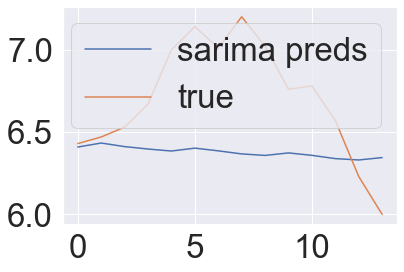

In [61]:
plt.plot(range(0,14), sarima_preds, label = 'sarima preds')
plt.plot(range(0,14), test[0:14], label = 'true')
plt.legend()

In [45]:
sarima_rmse = np.sqrt(mean_squared_error(test[0:14].values, sarima_preds))
sarima_rmse

0.5101237923678045

A RMSE of 0.510 means the predictions differed from the real prices by an average of $0.510 accross the 14 days. Looking at the plot of true and predicted prices, one would observed significant underfitting in the SARIMA test model.

#### Gridsearched SARIMA

As with my ARMA model, I wanted to gridsearch SARIMA parameters for each capital markets stock to optimize performance. In addition to the p and q parameters from ARMA, I now search for d, the 'Integrated' component, and s, the 'Seasonal' component.

In [54]:
# Defining AR, I, MA, and S order components
p = range(0,2) # AR
d = range(0,2) # I
q = range(0,2) # MA
s = range(12, 13) # S 
# remember 4 for s
# try 3 for s

In [55]:
# Creating every combination of p, d, and q parameters
pdq = itertools.product(p, d, q)

# Converting from itertools product object to list
pdq = list(pdq)

In [56]:
# Creating every combination of seasonal(s) p, d, and q parameters
pdqs = itertools.product(p, d, q, s)

# Converting from itertools product object to list
pdqs = list(pdqs)

In [81]:
len(pdq)

8

In [82]:
len(pdqs)

8

In [52]:
num_iterations = len(pdq)*len(pdqs)
num_iterations

64

In [83]:
# Calculate all models(gridsearch)
sarima_results, sarima_fails = gridsearch_sarima(pdq, pdqs, train, test, n_days = 14)

# Identify best models based on RMSE and AIC, respectively
get_best_time_series(sarima_results)

[{'order': (1, 1, 1),
  'seasonal_order': (0, 0, 1, 12),
  'aic': -229.89053559080963,
  'rmse': 0.19138906913320622},
 {'order': (0, 0, 0),
  'seasonal_order': (0, 0, 0, 12),
  'aic': -250.54664370575057,
  'rmse': 0.192669220612501}]

In [57]:
# Compiling a list of the best performing order parameters for each stock
best_sarima_list = gridsearch_sarima_multiple(cm_df_list,
                                              pdq,
                                              pdqs, 
                                              end_train_date = end_train_date,
                                              end_test_date = end_test_date,
                                              n_days = 14)
best_sarima_list

[['SFE',
  [{'order': (1, 1, 0),
    'seasonal_order': (0, 1, 0, 12),
    'aic': 238.20954735412877,
    'rmse': 0.36353690906873903},
   {'order': (0, 1, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': -250.5466438515681,
    'rmse': 0.43519289647564013}]],
 ['SSSS',
  [{'order': (1, 0, 1),
    'seasonal_order': (1, 1, 0, 12),
    'aic': 447.1091966447708,
    'rmse': 0.339333942519705},
   {'order': (0, 1, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': 140.05361135263976,
    'rmse': 0.5015262420138863}]],
 ['CGBD',
  [{'order': (1, 1, 0),
    'seasonal_order': (0, 1, 1, 12),
    'aic': 154.82572140679758,
    'rmse': 0.1693926393498829},
   {'order': (1, 1, 1),
    'seasonal_order': (0, 0, 0, 12),
    'aic': 102.65656437804276,
    'rmse': 0.2588906887526319}]],
 ['GAIN',
  [{'order': (1, 0, 1),
    'seasonal_order': (1, 1, 1, 12),
    'aic': -167.04962885915705,
    'rmse': 0.1293157484162556},
   {'order': (0, 1, 0),
    'seasonal_order': (1, 0, 0, 12),
    'aic': -221.48

In [58]:
# Calculating mean RMSE accross all eight stocks
mean_RMSE = np.mean([i[1][0]['rmse'] for i in best_sarima_list])
mean_RMSE

0.29674205207055454

## SARIMAX

After detrending with SARIMA, I finally add exogenous regressors, which are additional features in addition to the time series element (the endogenous regressor). I use only the 10, 50, and 200 day moving averages, as these are the only additional features that add information.

In the steps below, I separate the test dataframe into sets of both the endogenous and exogenous regressors.

In [59]:
# Declaring columns to use as exogenous regressors
predictors = ['10_day_ma', '50_day_ma', '200_day_ma']

In [ ]:
# Selecting a testing dataframe from the list of dfs
sarimax_df = df_list[0]

In [ ]:
# Creating df of endogenous regressors
sarimax_endog = sarimax_df['close']

# Creating df of exogenous regressors
sarimax_exog = sarimax_df[predictors]

In [ ]:
# Endogenous regressors train/test split
endog_train = sarimax_endog[:end_train_date]
endog_test = sarimax_endog[end_train_date:end_test_date]

In [85]:
endog_test

datetime
2020-12-01 06:00:00    12.29
2020-12-02 06:00:00    12.41
2020-12-03 06:00:00    13.16
2020-12-04 06:00:00    13.10
2020-12-07 06:00:00    12.91
2020-12-08 06:00:00    13.08
2020-12-09 06:00:00    13.04
2020-12-10 06:00:00    12.64
2020-12-11 06:00:00    12.42
2020-12-14 06:00:00    12.33
2020-12-15 06:00:00    12.62
2020-12-16 06:00:00    12.52
2020-12-17 06:00:00    12.07
2020-12-18 06:00:00    11.95
Name: close, dtype: float64

In [86]:
# Exogenous regressors train/test split
exog_train = sarimax_exog[:end_train_date]
exog_test = sarimax_exog[end_train_date:end_test_date]

In [87]:
exog_test

,10_day_ma,50_day_ma,200_day_ma
datetime,,,
2020-12-01 06:00:00,11.699897,10.507616,9.388734
2020-12-02 06:00:00,11.829007,10.582220,9.418815
2020-12-03 06:00:00,12.071006,10.683309,9.456064
2020-12-04 06:00:00,12.258095,10.778081,9.492345
2020-12-07 06:00:00,12.376624,10.861686,9.526373
2020-12-08 06:00:00,12.504510,10.948679,9.561754
2020-12-09 06:00:00,12.601872,11.030691,9.596384
2020-12-10 06:00:00,12.608804,11.093801,9.626687
2020-12-11 06:00:00,12.574476,11.145809,9.654498


### Test Model

In [88]:
# Instantiating SARIMA model
sarimax = SARIMAX(endog = endog_train,
                  exog = exog_train,
                  order = (1, 1, 1),
                  seasonal_order = (1, 1, 1, 12),
                  enforce_stationarity = False,
                  enforce_invertibility = False
               )

# Fitting SARIMAX to the training data
fitted_sarimax = sarimax.fit()

# Forecasting 14 days after training data
sarimax_preds = fitted_sarimax.forecast(steps = 14, exog = exog_test)

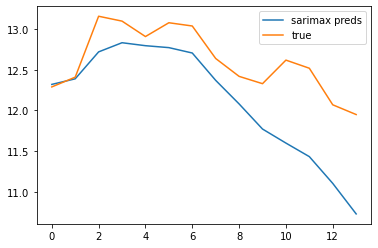

In [89]:
plt.plot(range(0,14), sarimax_preds, label = 'sarimax preds')
plt.plot(range(0,14), endog_test[:14], label = 'true')
plt.legend()

In [90]:
sarimax_rmse = np.sqrt(mean_squared_error(endog_test[:14].values, sarimax_preds))
sarimax_rmse

0.6346610300741182

While the performance on the test stock is the worst of the three models (0.635 RMSE), the above plot of the predictions versus true prices shows the model is underfitting much less than it was for the SARIMA and ARMA models.

### Gridsearched SARIMAX

In [65]:
# Defining AR, I, MA, and S order components
p = range(0,2) # AR
d = range(0,2) # I
q = range(0,2) # MA
s = range(12,13) # S
# remember 4 for s
# try 3 for s

In [66]:
# Creating every combination of p, d, and q parameters
pdq = itertools.product(p, d, q)

# Converting from itertools product object to list
pdq = list(pdq)

In [67]:
# Creating every combination of seasonal(s) p, d, and q parameters
pdqs = itertools.product(p, d, q, s)

# Converting from itertools product object to list
pdqs = list(pdqs)

In [80]:
len(pdq)

8

In [81]:
len(pdqs)

8

In [82]:
num_iterations = len(pdq)*len(pdqs)
num_iterations

64

In [69]:
best_sarimax_list = gridsearch_sarimax_multiple(cm_df_list, 
                                                pdq, 
                                                pdqs,
                                                end_train_date = end_train_date,
                                                end_test_date = end_test_date,
                                                exog_vars = ['10_day_ma', '50_day_ma', '200_day_ma'])

In [70]:
best_sarimax_list

[['SFE',
  [{'order': (0, 1, 0),
    'seasonal_order': (1, 1, 1, 12),
    'aic': -545.6651455213502,
    'rmse': 0.15740526039060102},
   {'order': (1, 0, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': -610.8989800622433,
    'rmse': 0.3224906206027759}]],
 ['SSSS',
  [{'order': (0, 1, 0),
    'seasonal_order': (1, 0, 0, 12),
    'aic': -207.73002876285145,
    'rmse': 0.2224975819131915},
   {'order': (1, 0, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': -223.1122034329129,
    'rmse': 0.31355460927551204}]],
 ['CGBD',
  [{'order': (1, 0, 0),
    'seasonal_order': (0, 1, 1, 12),
    'aic': -211.40656657894715,
    'rmse': 0.14678626224369984},
   {'order': (1, 1, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': -264.01244543664535,
    'rmse': 0.3293270908224408}]],
 ['GAIN',
  [{'order': (0, 0, 0),
    'seasonal_order': (0, 1, 0, 12),
    'aic': 581.7748040834222,
    'rmse': 0.12647008705719992},
   {'order': (1, 0, 0),
    'seasonal_order': (1, 0, 0, 12),
    'aic': -5

In [71]:
# Calculating mean RMSE accross all eight stocks
mean_RMSE = np.mean([i[1][0]['rmse'] for i in best_sarimax_list])
mean_RMSE

0.1964040423230358

While the test model performed the worst of the three, the SARIMAX model has performed the best on average accross all stocks in the capital markets sample with an average RMSE of 0.196.

## LSTM RNN

Next I wanted to try a neural network. A vanilla recurrent neural network is not optimal for this application as it is unable to retain substantial information from early in the time series. As a result, I use layers made up of Long-Short Term Memory cells, as they have less information loss due to the configuration of their cells. Each cell has three activation functions, each controlling a different aspect of the cell's memory, whereas traditional RNN cells only have one.

In testing different model hyperparameter and architecture configurations, I split my experimental data into a training and a test set. The test set contains data from the most recent 14 days. The training set is split into numerous input and output sets, which together form a 3D tensor to be fed into the first LSTM layer. The splitting follows this format: given a sequence [1, 2, 3, 4, 5, 6, 7], the split sequence is: <br>
<br>
<center> Input - $\begin{bmatrix} 1 & 2 & 3 \\ 2 & 3 & 4 \\ 3 & 4 & 5 \end{bmatrix}$  Output - $\begin{bmatrix} 4 & 5 \\ 5 & 6 \\ 6 & 7 \end{bmatrix}$, with each row being an input-output pair. </center>

In tuning hyperparameters, I consult the model's bias/variance as shown by the relationship between the training and testing RMSE. The function I used to split the training data was taken from [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/).

### Test Models

In [32]:
# Instantiate a dataframe for testing
df_test = cm_df_list[0]

# Remove exogenous regressors
df_test = df_test['close']

# Endogenous regressors train/test split
rnn_train = df_test[:end_train_date]
rnn_test = df_test[end_train_date:end_test_date]

In [33]:
rnn_train.shape

(719,)

In [34]:
rnn_test.shape

(14,)

In [110]:
# Setting raw input sequence
raw_seq = rnn_train.values

# Setting number of input and output/forecast steps
# 'From the past 365 trading days, predict the next 14'
n_steps_in, n_steps_out = 100, 14

# Splitting the sequence
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# Number of features is one because time series is univariate
n_features = 1

# Reshape from (samples, timesteps) into (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], n_features)

In [111]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, input_shape = (n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

In [112]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False)

In [113]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [114]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [115]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [116]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 0.18668411251391234 Test: 0.5322122784648595


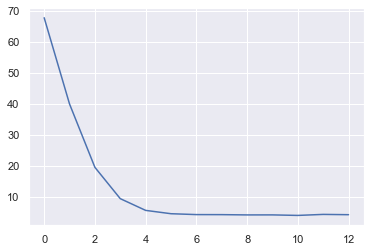

In [117]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

## Hyperparameter and Architecture Tuning

### Tanh Activation

I want to test if a tanh activation will outperform a ReLu. In order to do this, I need to normalize my input data, as tanh functions can suffer from vanishing and exploding gradients.

In [92]:
# Setting raw input sequence
raw_seq = rnn_train.values

# Reshaping raw_seq from one dimensional to two dimensional vector for scaling
raw_seq = raw_seq.reshape(raw_seq.shape[0], 1)

# Fitting a normalizing scaler
scaler = MinMaxScaler()
scaler.fit(raw_seq)

# Setting number of input and output/forecast steps
# 'From the past n_steps_in trading days, predict the next n_steps_out'
n_steps_in, n_steps_out = 100, 14

# Splitting the sequence
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# Number of features is one because time series is univariate
n_features = 1

# Reshape from (samples, timesteps) into (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], n_features)

# Scaling X with normalization
for i in range(X.shape[0]):
        X[i] = scaler.transform(X[i])

In [108]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape = (n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [109]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False, callbacks = history)

KeyboardInterrupt: 

In [ ]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape X_train from 1D to 2D vector
X_train = X_train.reshape(X_train.shape[0], 1)

# Scale train set
X_train = scaler.transform(X_train)

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape X_train from 1D to 2D vector
X_test = X_test.reshape(X_test.shape[0], 1)

# Scale test set
X_test = scaler.transform(X_test)

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [52]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [53]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [54]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 0.27054933682898524 Test: 0.45451771548966885


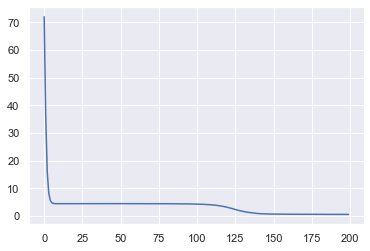

In [55]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

In [60]:
import pydot

In [62]:
plot_model(model, show_shapes = True, show_layer_names = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


There seems to be little difference in model performance between the two activation functions. Going forward, I will use the ReLu as it does not require scaling.

### Dropout Regularization

So far, the model seems to be overfitting to the training data, as its training performance is better than its testing performance. I'll add dropout regularization to attempt to increase the bias.

In [64]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, input_shape = (n_steps_in, n_features)))
model.add(Dropout(.05))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [65]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False, callbacks = history)

In [66]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [67]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [68]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [69]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 7.768565800831677 Test: 7.460020521401312


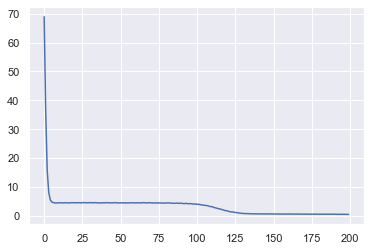

In [70]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

Dropout regularization seems to slightly improve model performance but could just be due to increasing the number of hidden units in the first LSTM layer from 50 to 100. Hard to tell because of inconsistent results.

Can I improve performance by adding another lstm layer, try bidirectional, then trying GRU layers, also training for longer

### Bidirectional LSTM

In [71]:
# Define model architecture
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape = (n_steps_in, n_features))))
model.add(Dropout(.05))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [72]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False, callbacks = history)

In [73]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [74]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [75]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [76]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 7.7200484270402585 Test: 7.405773135719215


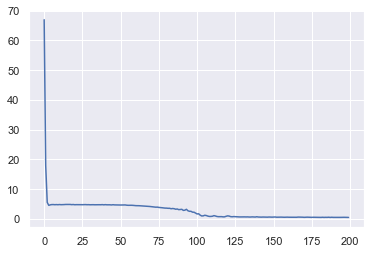

In [77]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

## Two LSTM layers

In [100]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (n_steps_in, n_features)))
model.add(LSTM(50))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [101]:
# Fit the model
model.fit(X, y, epochs = 100, verbose = False, shuffle = False, callbacks = history)

In [102]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape X_train from 1D to 2D vector
X_train = X_train.reshape(X_train.shape[0], 1)

# Scale train set
X_train = scaler.transform(X_train)

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape X_train from 1D to 2D vector
X_test = X_test.reshape(X_test.shape[0], 1)

# Scale test set
X_test = scaler.transform(X_test)

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [103]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [104]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [105]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 2.365626215306599 Test: 2.0762797428279285


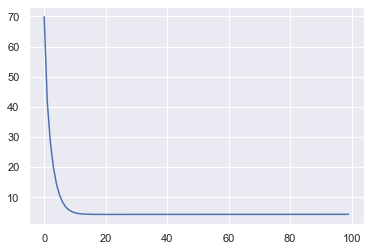

In [106]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

### Multiple LSTM, Dense Layers with Dropout

In [118]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (n_steps_in, n_features)))
model.add(LSTM(50))
model.add(Dropout(.05))
model.add(Dense(25))
model.add(Dropout(.1))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [119]:
# Fit the model
model.fit(X, y, epochs = 250, verbose = False, shuffle = False, callbacks = history)

In [120]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [121]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [122]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [123]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 0.30009165807107835 Test: 0.5903683961295644


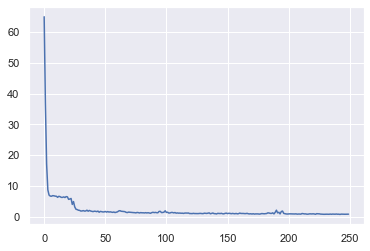

In [124]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

In [125]:
plot_model(model, show_shapes = True, show_layer_names = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Training Accross All Stocks

In [561]:
def rnn_multiple(df_list, n_steps_in, n_steps_out, end_train_date, end_test_date):
    """
    Takes in a list of dataframes, number of input and output steps, 
    and dates to end train and test sets.
    
    df_list -- list of dataframes
    n_steps_in -- integer
    n_steps_out -- integer
    end_train_date -- string in 'YYYY-MM-DD' format where the date field is optional
    end_test_date -- string in 'YYYY-MM-DD' format where the date field is optional
    """
    # Create list of results to store scores and fail cache to store failed dfs
    results_list = []
    fail_cache = []
    
    for df in df_list:
        try:
            # Define a dictionary to store model performance on each stock
            result = {}

            # Get ticker and add to result dictionary
            result['ticker'] = df['ticker'][0]

            # Remove exogenous regressors
            df = df['close']

            # Endogenous regressors train/test split
            rnn_train = df[:end_train_date]
            rnn_test = df[end_train_date:end_test_date]

            # Setting raw input sequence
            raw_seq = rnn_train.values

            # Reshaping raw_seq from one dimensional to two dimensional vector for scaling
            raw_seq = raw_seq.reshape(raw_seq.shape[0], 1)

            # Fitting a normalizing scaler
            scaler = MinMaxScaler()
            scaler.fit(raw_seq)

            # Setting number of input and output/forecast steps
            # 'From the past n_steps_in trading days, predict the next n_steps_out'
            n_steps_in, n_steps_out = 100, 14

            # Splitting the sequence
            X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

            # Number of features is one because time series is univariate
            n_features = 1

            # Reshape from (samples, timesteps) into (samples, timesteps, features)
            X = X.reshape(X.shape[0], X.shape[1], n_features)

            # Scaling X with normalization
            for i in range(X.shape[0]):
                    X[i] = scaler.transform(X[i])

            # Define model architecture
            model = Sequential()
            model.add(LSTM(100, activation = 'tanh', return_sequences = True, input_shape = (n_steps_in, n_features)))
            model.add(LSTM(50, activation = 'tanh'))
            model.add(Dropout(.05))
            model.add(Dense(25))
            model.add(Dropout(.1))
            model.add(Dense(n_steps_out))
            model.compile(optimizer = 'adam', loss = 'mse')

            # Instantiate History object to plot loss
            history = History()

            # Fit the model
            model.fit(X, y, epochs = 250, verbose = False, shuffle = False, callbacks = history)

            # Set train evaluation input and outputs
            X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
            y_train = rnn_train.values[-n_steps_out:]

            # Reshape input
            X_train = X_train.reshape(1, n_steps_in, n_features)

            # Set test evaluation input and outputs
            X_test = rnn_train.values[-n_steps_in:]
            y_test = rnn_test.values

            # Reshape input 
            X_test = X_test.reshape(1, n_steps_in, n_features)

            # Predicting on train and test sets
            y_pred_train = model.predict(X_train, verbose = False)[0]
            y_pred_test = model.predict(X_test, verbose = False)[0]
            # [0] is to access nested array

            # Calculate RMSE for train and test predictions
            result['train_rmse'] = np.sqrt(mean_squared_error(y_train, y_pred_train))
            result['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_test))

            # Define loss variable for plotting
            result['loss'] = history.history['loss']

            # Append result dictionary to results_list
            results_list.append(result)
            
        except:
            fail_cache.append(df['ticker'][0])
            continue
            
    return results_list, fail_cache   

In [562]:
rnn_list, rnn_failed = rnn_multiple(cm_df_list, 
                                    n_steps_in = 100, 
                                    n_steps_out = 14, 
                                    end_train_date = end_train_date, 
                                    end_test_date = end_test_date)

KeyError: 'ticker'

In [563]:
rnn_list

NameError: name 'rnn_list' is not defined

## Conclusion and Next Steps

The highest performing classification model was the KNN, though this is only on a sample of 8 out of 160. I'd like to predict on the entire set of 160, add additional models, and add an ensemble voting classifier.

For the eight small cap stocks I employed an ARMA model on, the average RMSE accross the 14 days was .287.

To further improve the models I have, I'd like to add more features, such as momentum indicators like Moving Average Convergence/Divergence (MACD) and Relative Strength Index (RSI), as well as a volatility indicator like Standard Deviation or Beta. I'd also like to add a percent-change-in-volume feature.

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    """
    Split a sequence into samples
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)